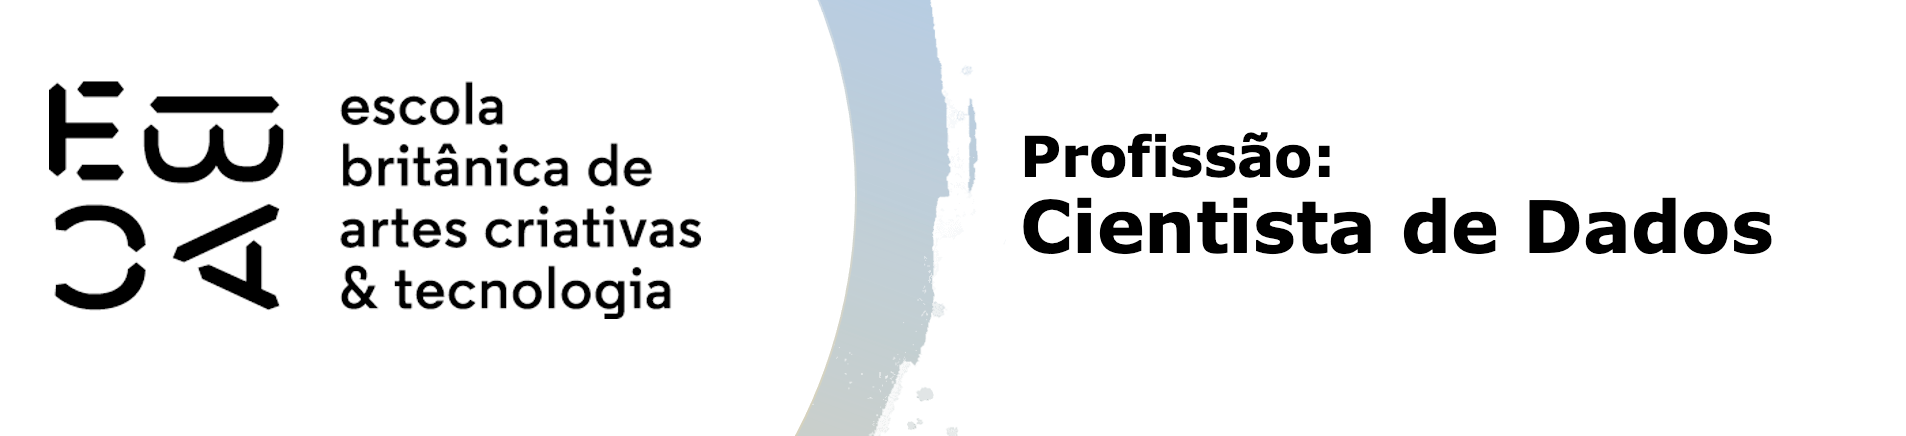

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns

from tqdm.notebook         import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.metrics       import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# dropna=False -> incluirá contagens dos valores nulos (NaN) no resultado.
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
colunas = df.iloc[:, :6].columns
colunas

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration'],
      dtype='object')

In [6]:
# confirmação de que não há valores faltantes nas colunas
df[colunas].isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

In [7]:
df[colunas].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 578.1 KB


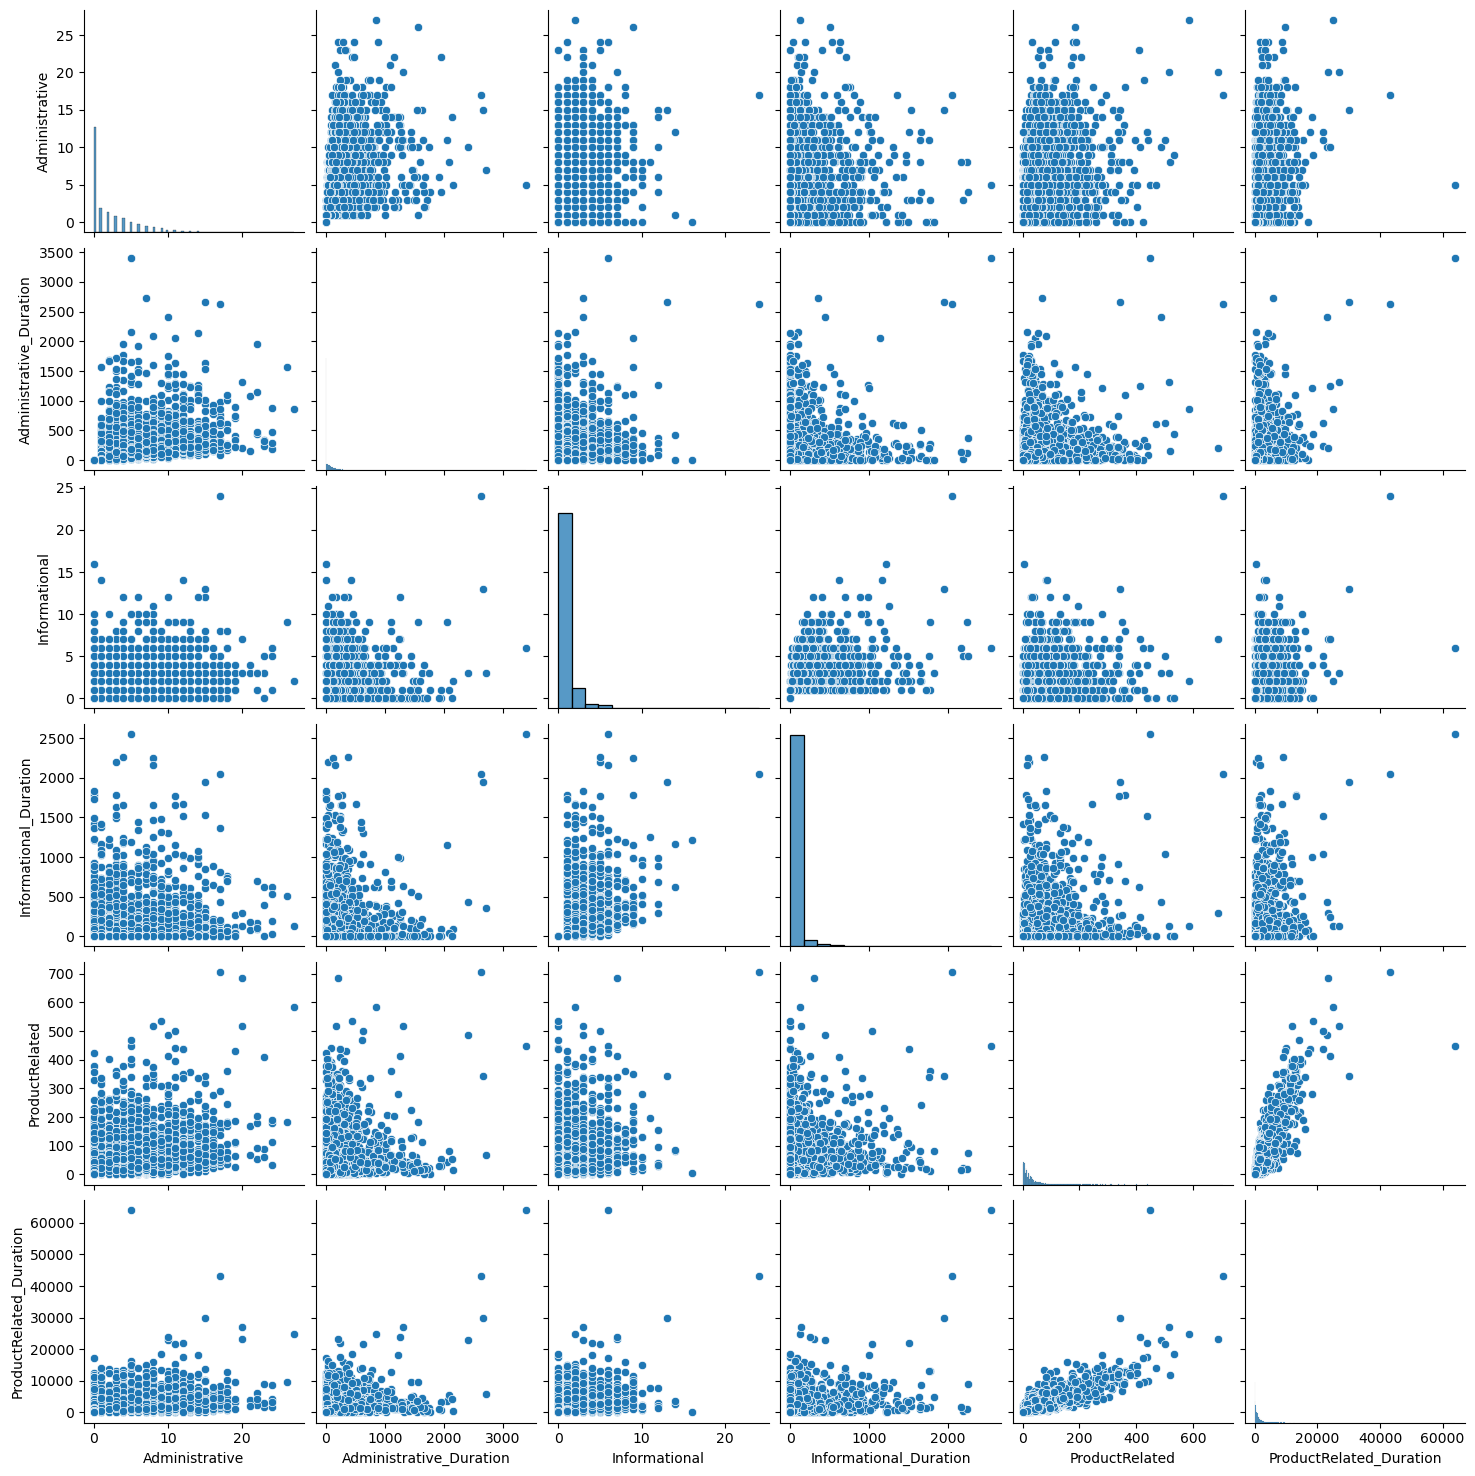

In [8]:
# visualizzação da correlação entre os dados sem nenhuma alteração ou padronização
sns.pairplot(data = df[colunas])
plt.show()

## Pré-Processamento - Padronização das Features escalando-as para ter uma média zero e um desvio padrão de um.
- Devido aos gráficos anteriores não mostrarem nenhum tipo de agrupamento relevante, notamos escalas muito diferentes que podem interferir no resultado final devido à diferença de Variância ser muito maior para uma váriavel específica o que resultaria em uma maior relevância fazendo com que o resultado final desenvolva tendências indesejadas.

In [9]:
# Cópia do DataFrame, para nova variável df_pad
df_pad = df.copy()

# Somente valores numéricos
colunas_numericas = df_pad.select_dtypes(include = 'number').columns
colunas_numericas

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')

In [10]:
# Padronizando valores numéricos, preservando o Dataframe completo
df_pad[colunas_numericas] = pd.DataFrame(data=StandardScaler().fit_transform(df_pad[colunas_numericas]), 
                                         columns=df_pad[colunas_numericas].columns)
df_pad

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,Feb,-1.233426,-0.790293,-0.894178,-0.762629,Returning_Visitor,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,Feb,-0.136078,-0.207952,-0.894178,-0.514182,Returning_Visitor,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,Feb,2.058618,-0.790293,2.437081,-0.265735,Returning_Visitor,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,Feb,0.961270,-0.207952,-0.477771,-0.017289,Returning_Visitor,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,Feb,0.961270,0.374389,-0.894178,-0.017289,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,-0.310366,-0.288966,0.342125,-0.308821,Dec,2.058618,2.121412,-0.894178,-0.762629,Returning_Visitor,True,False
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,-0.457683,-0.447364,-0.317178,-0.308821,Nov,0.961270,-0.207952,-0.894178,0.976499,Returning_Visitor,True,False
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,1.261014,0.897093,-0.317178,-0.308821,Nov,0.961270,-0.207952,-0.894178,2.218733,Returning_Visitor,True,False
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,-0.457683,-0.453140,-0.317178,-0.308821,Nov,-0.136078,-0.207952,-0.061364,1.721839,Returning_Visitor,False,False


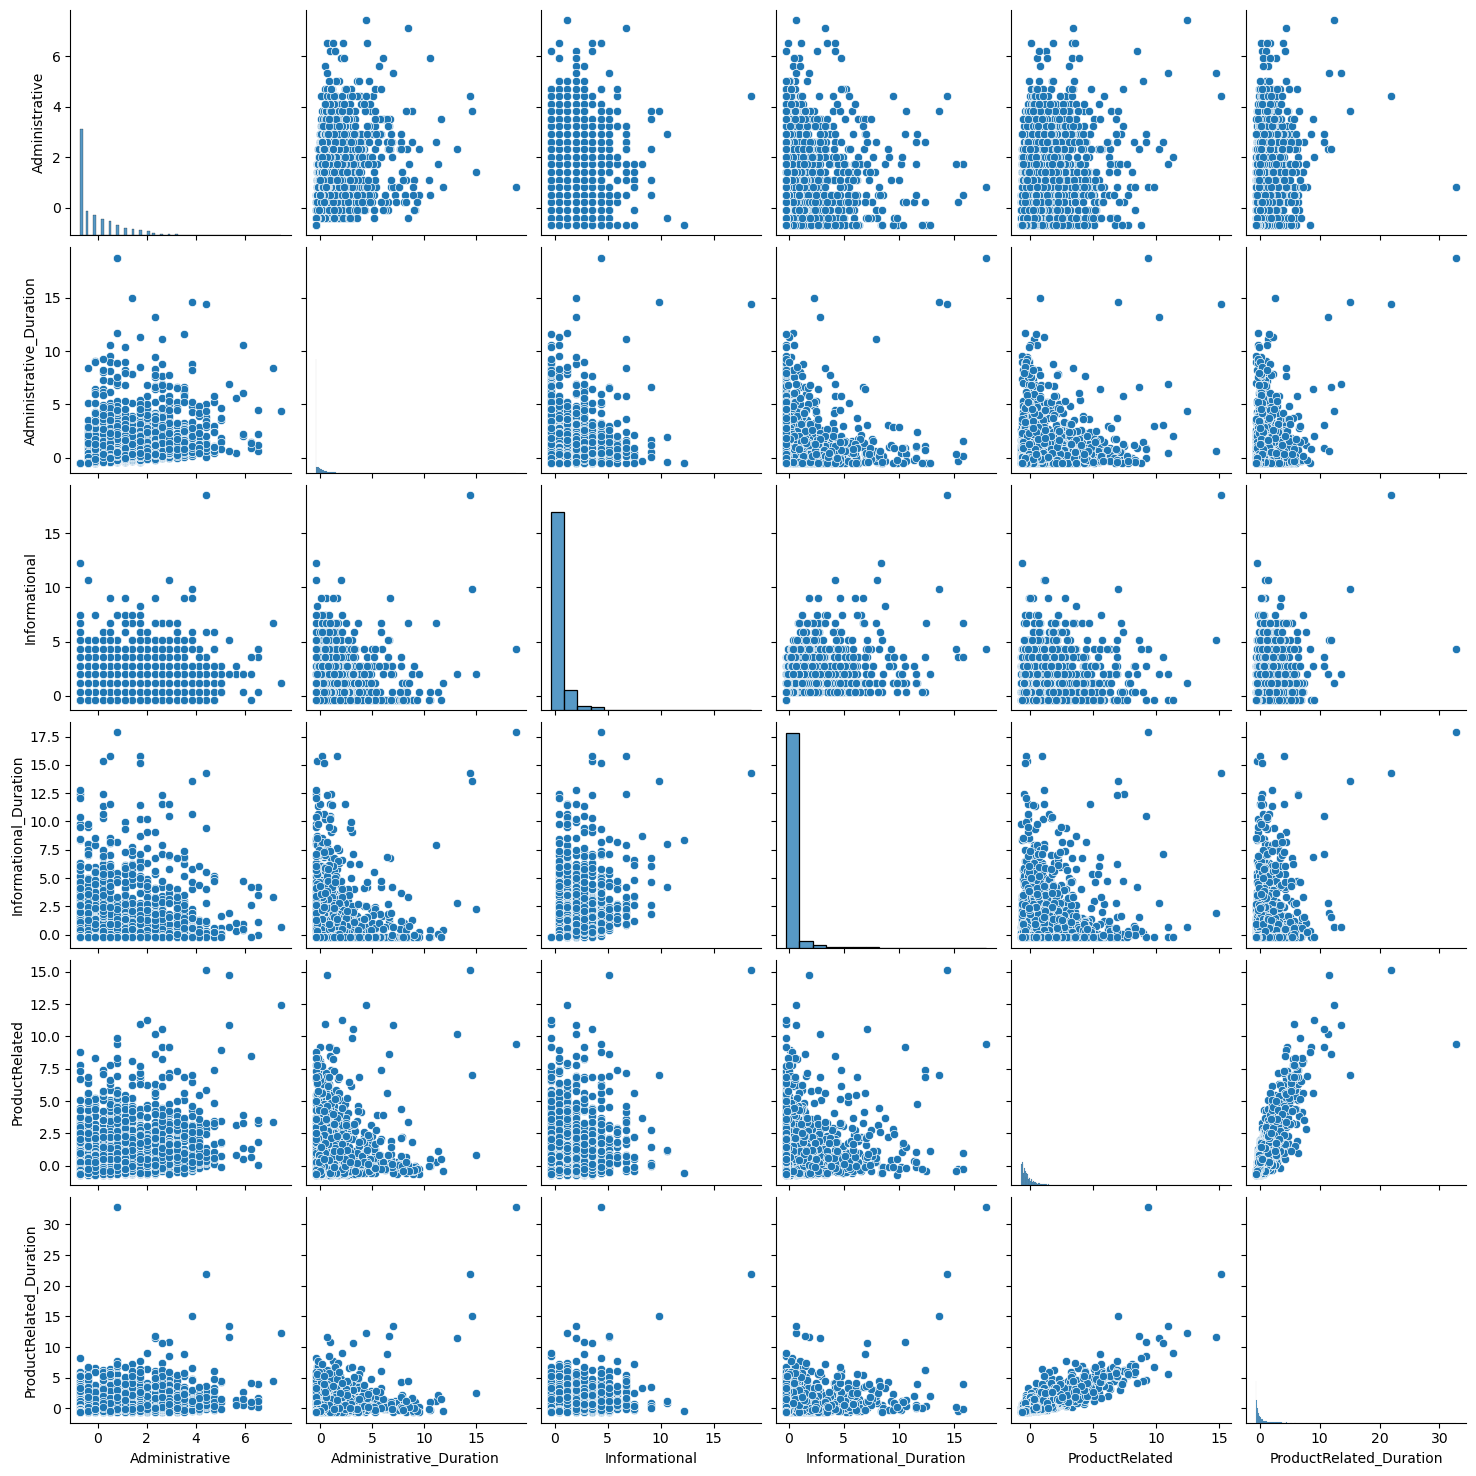

In [11]:
# visualizzação da correlação entre os dados com padronização 
sns.pairplot(data = df_pad[colunas])
plt.show()

**Após padronizar as variáveis, não há agrupamentos no gráfico de forma clara. O objetivo da padronização é garantir que todas as variáveis tenham a mesma influência na formação de grupos.**

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

#### Método do Cotovelo

  0%|          | 0/15 [00:00<?, ?it/s]

    n_clusters           SQD
0            1  73980.000000
1            2  51210.558199
2            3  43203.311109
3            4  37464.139172
4            5  33726.062000
5            6  29688.042722
6            7  26903.007807
7            8  25196.210134
8            9  22477.240024
9           10  21130.687406
10          11  19703.156489
11          12  19503.847760
12          13  18242.254470
13          14  17777.778741
14          15  16916.741816


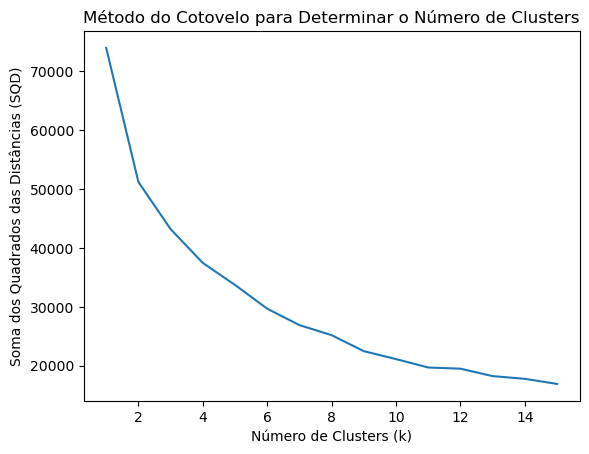

In [12]:
# lista vazia para armazenar as somas dos quadrados das distâncias 'sqd'
SQD = []

# N_clusters
K = 15

# Calcula o K-Means para cada valor K
for k in tqdm(range(1, K + 1)):
    km = KMeans(n_clusters = k, n_init = 'auto')
    km = km.fit(df_pad[colunas])
    SQD.append(km.inertia_)

# Criação de um DataFrame CONTADOR + N_CLUSTERS
df_sqd = pd.DataFrame(data = {'n_clusters': list(range(1, len(SQD) + 1)), 'SQD': SQD})
print(df_sqd)

# Criação do gráfico para visualização do método do cotovelo.
plt.plot(df_sqd['n_clusters'], df_sqd['SQD'])
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Soma dos Quadrados das Distâncias (SQD)')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.show()

#### Coef. da Silhueta

  0%|          | 0/9 [00:00<?, ?it/s]

   n_clusters  silhueta_media
0           2        0.624972
1           3        0.508971
2           4        0.498958
3           5        0.510365
4           6        0.477927
5           7        0.469843
6           8        0.473163
7           9        0.412102
8          10        0.410765


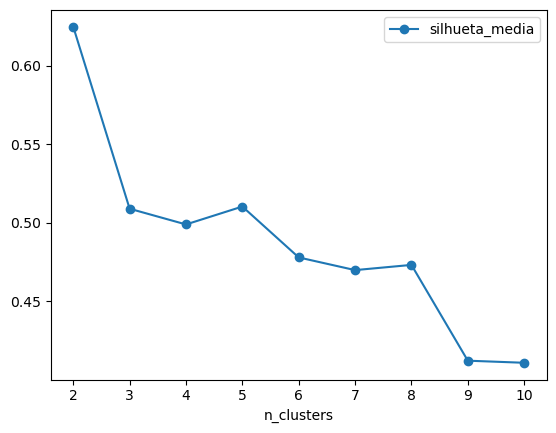

In [13]:
# Lista vazia para armazenar os Coef. da Silhuetas
silhuetas = []

# N_clusters
max_clusters = 10

# Calcula o K-Means para cada valor de N_clusters 
for n_clusters in tqdm(range(2, max_clusters + 1)):
    
    # Executa o K-Means com o número de clusters atual.
    km = KMeans(n_clusters = n_clusters, n_init = 'auto').fit(df_pad[colunas])
    
    # Calculo para Coef de Silhueta
    silhuetas.append(silhouette_score(df_pad[colunas], labels = km.labels_))

    #Nomeando grupos verificados pelo k-Means.
    nomes_grupos = ['grupo_' + str(n) for n in range(n_clusters)]
    
    # Adiciona uma nova coluna ao DataFrame df_pad_ com os rótulos dos grupos
    df_pad['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(codes = km.labels_, 
                                                                  categories = nomes_grupos)    

# DataFrame Coeficiente da Silhueta média X N_clusters
df_silhueta = pd.DataFrame(data = {'n_clusters': list(range(2, max_clusters + 1)), 
                                   'silhueta_media': silhuetas})
print(df_silhueta)

# Criação do gráfico
df_silhueta.plot.line(x = 'n_clusters', 
                      y = 'silhueta_media', 
                      marker = 'o')

plt.show()

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

Text(0.5, 1.0, 'Quantidade de clientes em grupos_2 ')

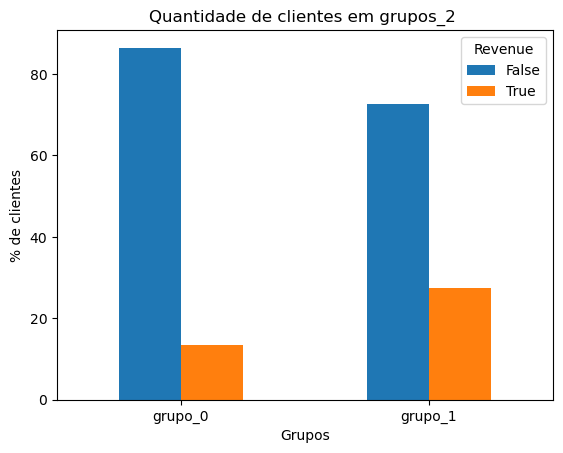

In [30]:
# agrupando grupos em relaçao a venda
df_group = df_pad.groupby(['grupos_2', 'Revenue'], observed=False)['Revenue'].count().unstack()

# Utilizando porcentagem por grupo
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100

#definindo gráfico:
ax = df_porcentagem.plot.bar(rot=0)
ax.set_ylabel('% de clientes')
ax.set_xlabel('Grupos')
plt.title('Quantidade de clientes em grupos_2 ')

Text(0.5, 1.0, 'Quantidade de clientes em grupos_3')

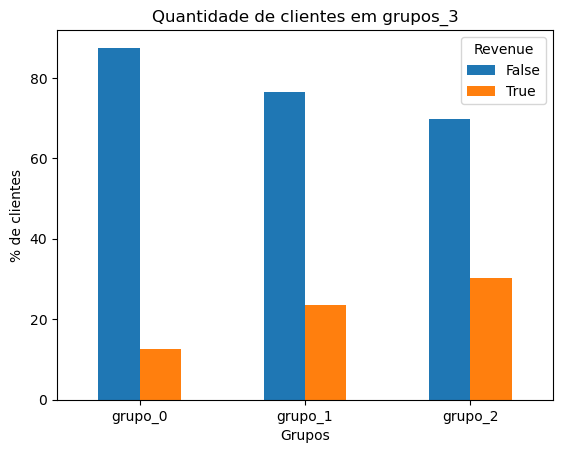

In [31]:
# agrupando grupos em relaçao a venda
df_group = df_pad.groupby(['grupos_3', 'Revenue'], observed=False)['Revenue'].count().unstack()

# Utilizando porcentagem por grupo
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100

#definindo gráfico:
ax = df_porcentagem.plot.bar(rot=0)
ax.set_ylabel('% de clientes')
ax.set_xlabel('Grupos')
plt.title('Quantidade de clientes em grupos_3')

Text(0.5, 1.0, 'Quantidade de clientes em grupos_4')

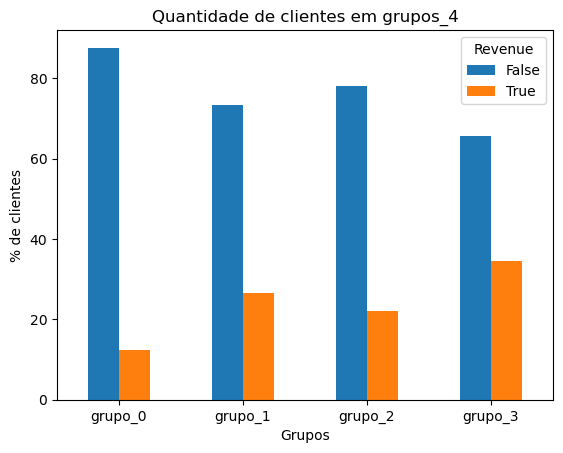

In [32]:
# agrupando grupos em relaçao a venda
df_group = df_pad.groupby(['grupos_4', 'Revenue'], observed=False)['Revenue'].count().unstack()

# Utilizando porcentagem por grupo
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100

#definindo gráfico:
ax = df_porcentagem.plot.bar(rot=0)
ax.set_ylabel('% de clientes')
ax.set_xlabel('Grupos')
plt.title('Quantidade de clientes em grupos_4')

In [36]:
# Cópia de df_pad para análise das váriaveis
df_pad_graf = df_pad.copy()

# Definindo nome para váriaveis grupos_3
df_pad_graf['grupos_3'] = df_pad_graf['grupos_3'].cat.rename_categories({'grupo_0': 'Especulador', 
                                                                         'grupo_1': 'Suposto comprador', 
                                                                         'grupo_2': 'Comprador'})

# Definindo nome para váriaveis grupos_4
df_pad_graf['grupos_4'] = df_pad_graf['grupos_4'].cat.rename_categories({'grupo_0': 'Especulador', 
                                                                         'grupo_1': 'Suposto Comprador', 
                                                                         'grupo_2': 'Em dúvida',
                                                                         'grupo_3': 'Comprador'})

Text(0.5, 1.0, 'Quantidade de clientes em grupos_3')

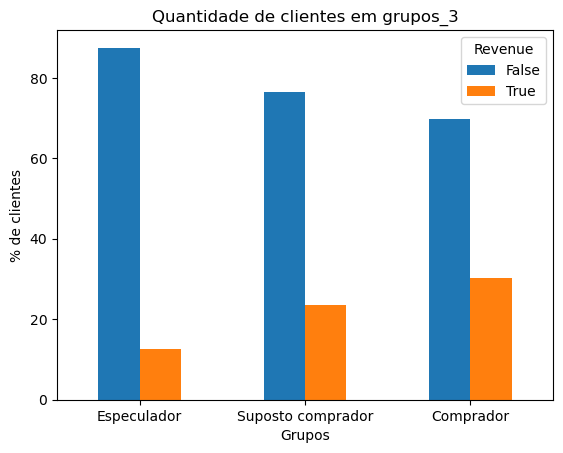

In [37]:
# agrupando grupos em relaçao a venda
df_group = df_pad_graf.groupby(['grupos_3', 'Revenue'], observed=False)['Revenue'].count().unstack()

# Utilizando porcentagem por grupo
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100

#definindo gráfico:
ax = df_porcentagem.plot.bar(rot=0)
ax.set_ylabel('% de clientes')
ax.set_xlabel('Grupos')
plt.title('Quantidade de clientes em grupos_3')

Text(0.5, 1.0, 'Quantidade de clientes em grupos_4')

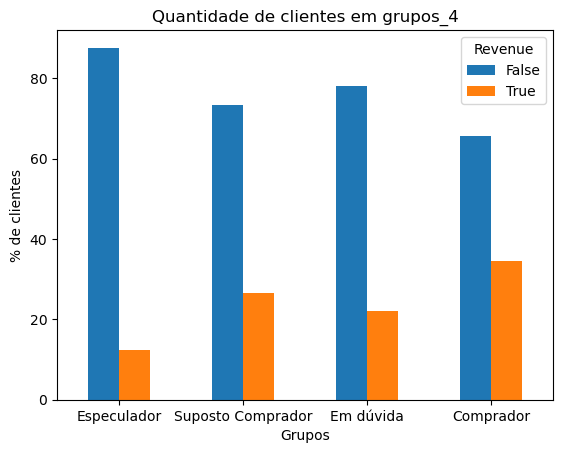

In [38]:
# agrupando grupos em relaçao a venda
df_group = df_pad_graf.groupby(['grupos_4', 'Revenue'], observed=False)['Revenue'].count().unstack()

# Utilizando porcentagem por grupo
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100

#definindo gráfico:
ax = df_porcentagem.plot.bar(rot=0)
ax.set_ylabel('% de clientes')
ax.set_xlabel('Grupos')
plt.title('Quantidade de clientes em grupos_4')

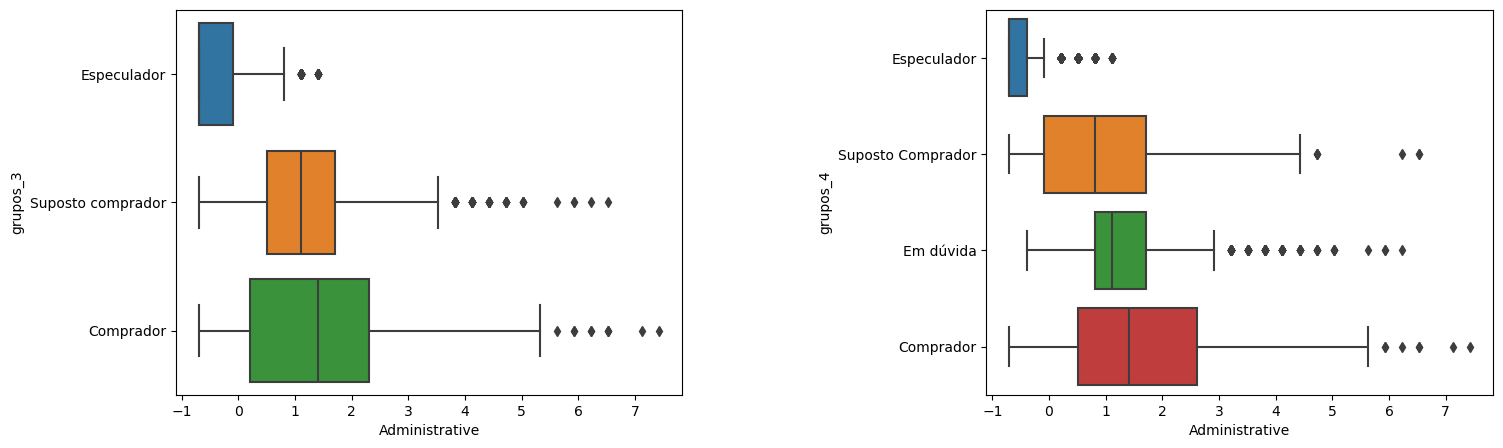

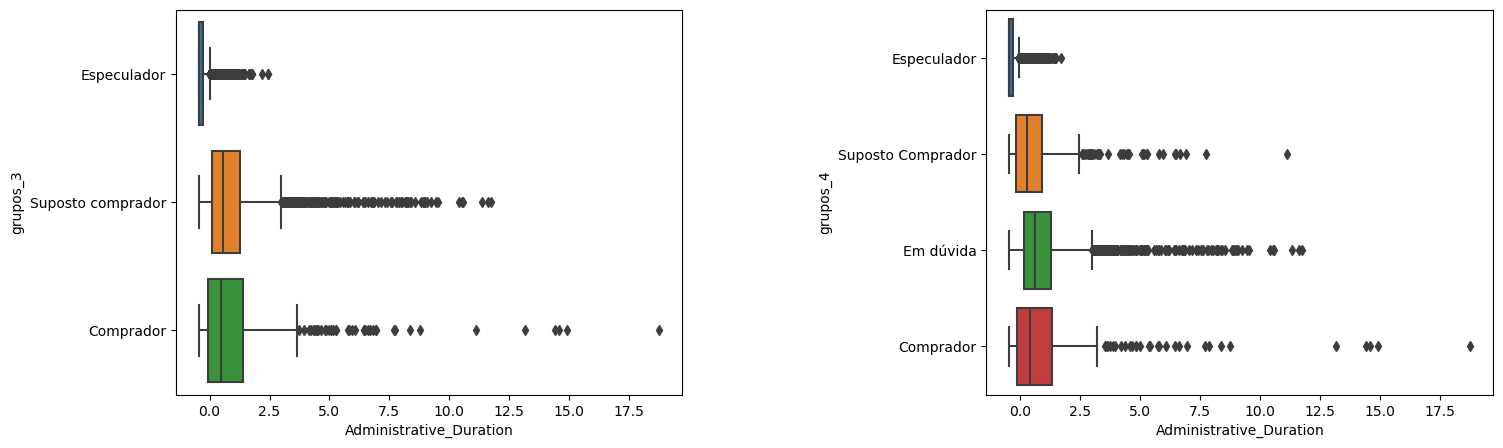

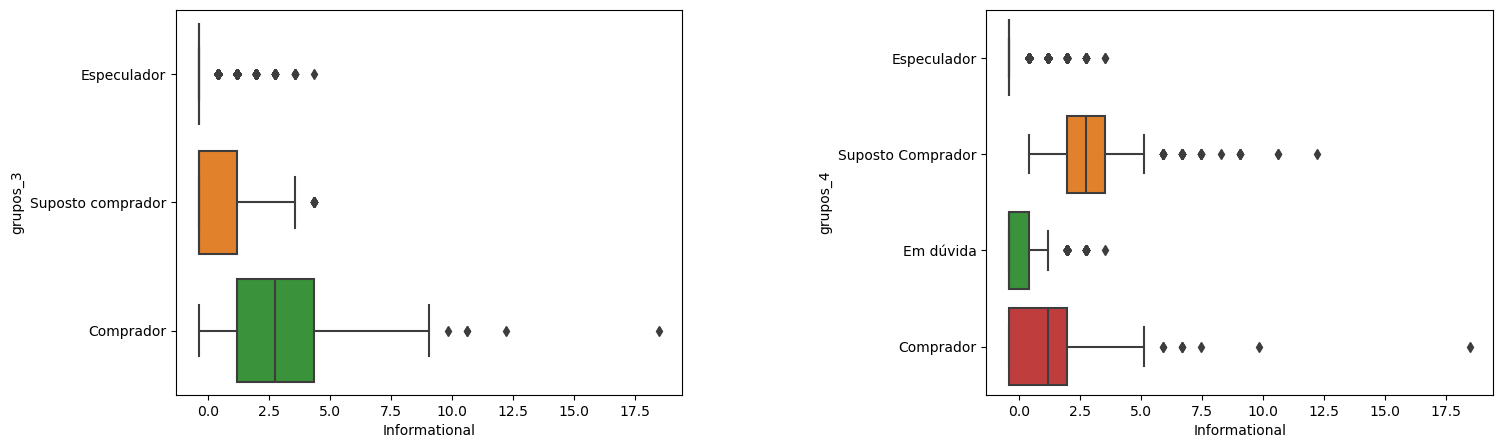

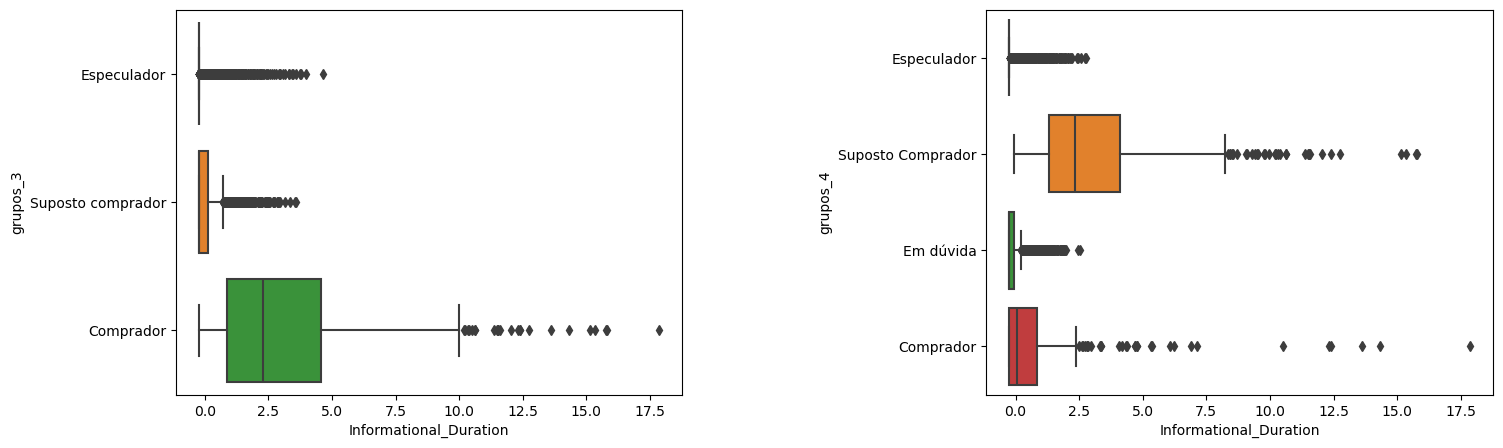

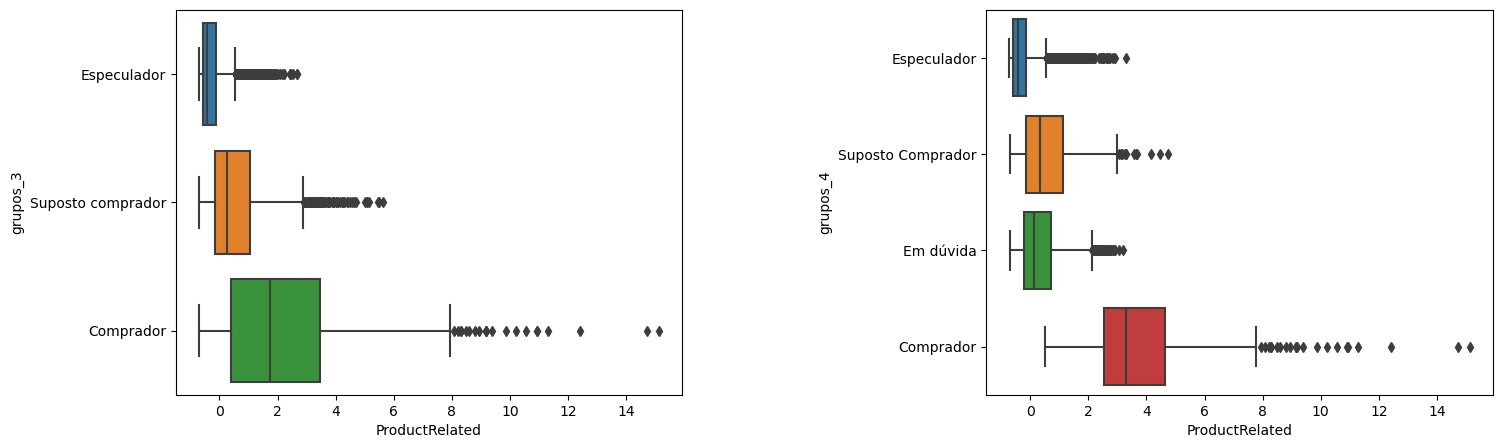

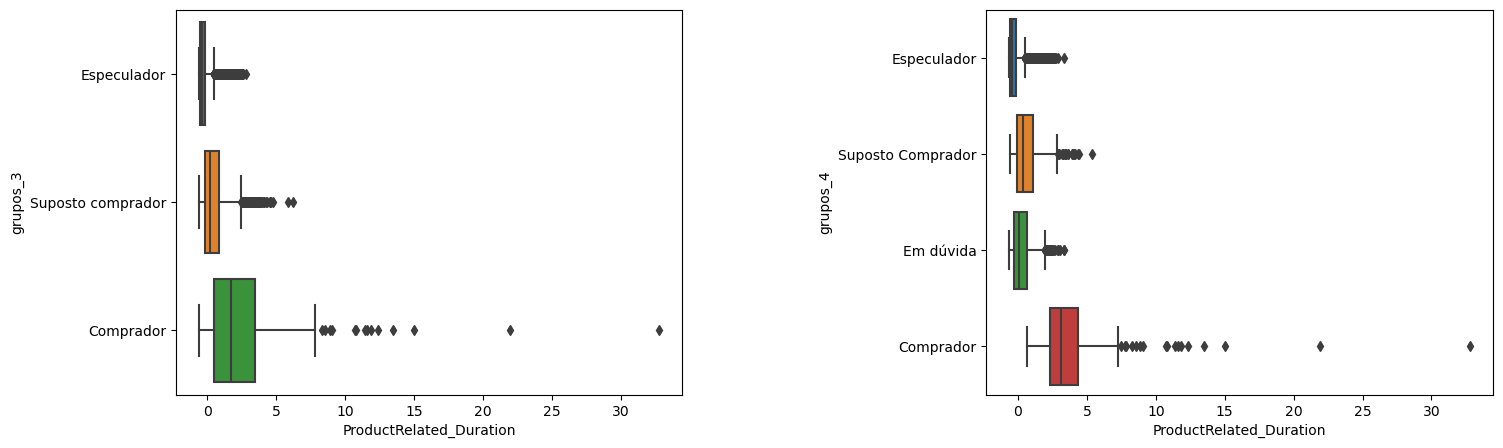

In [47]:
# Loop de boxplots para cada variáveis numéricas 'colunas'.
for n in range(6):
    # Definição dos plots
    fig, ax = plt.subplots(1, 2, figsize=(17, 5))
    
    # Boxplot 'grupos_3'
    sns.boxplot(data=df_pad_graf, x=colunas[n], y='grupos_3', ax=ax[0])
    
    # Boxplot 'grupos_4'
    sns.boxplot(data=df_pad_graf, x=colunas[n], y='grupos_4', ax=ax[1])

    plt.subplots_adjust(wspace=0.6)
    plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [155]:
df_group = df_pad_graf.groupby(['grupos_4', 'Revenue'], observed=False)['Revenue'].count().unstack()
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100
df_porcentagem

Revenue,False,True
grupos_4,,
Especulador,87.555846,12.444154
Suposto Comprador,73.333333,26.666667
Em dúvida,78.012590,21.987410
Comprador,65.508021,34.491979


In [156]:
df_porcentagem = df_porcentagem/400

print(f'''Para o "grupos_4":\n
O valor da porcentagem de False/não comprou = {((df_porcentagem.iloc[:,:1].sum())*100).values[0]}%
O valor da porcentagem de True/comprou = {((df_porcentagem.iloc[:,1:2].sum())*100).values[0]}%''')

Para o "grupos_4":

O valor da porcentagem de False/não comprou = 76.10244769721177%
O valor da porcentagem de True/comprou = 23.897552302788238%


In [157]:
df_group = df_pad_graf.groupby(['grupos_3', 'Revenue'], observed=False)['Revenue'].count().unstack()
df_porcentagem = df_group.div(df_group.sum(axis=1), axis=0) * 100
df_porcentagem


Revenue,False,True
grupos_3,,
Especulador,87.477256,12.522744
Suposto comprador,76.533115,23.466885
Comprador,69.685767,30.314233


In [158]:
df_porcentagem = df_porcentagem/300

print(f'''Para o "grupos_3":\n
O valor da porcentagem de False/não comprou = {((df_porcentagem.iloc[:,:1].sum())*100).values[0]}%
O valor da porcentagem de True/comprou = {((df_porcentagem.iloc[:,1:2].sum())*100).values[0]}%''')

Para o "grupos_3":

O valor da porcentagem de False/não comprou = 77.89871269589689%
O valor da porcentagem de True/comprou = 22.101287304103103%


> **O cluster "grupos_4" foi o que mais vendeu. com 23.9%.**<br>
> **Já o cluster "grupos_3" foi o que mais vendeu. com 22.1%.**<br>
> **A diferença entre vendas foi de apenas 1.8%.**